In [4]:
# You will need: 
# !pip install rouge_score 
# !pip install evaluate

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import evaluate

import nltk
import string
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Loading some metrics for evaluation
nltk.download("punkt")
meteor = evaluate.load('meteor')
rouge = evaluate.load('rouge')

[nltk_data] Downloading package punkt to /home/nbiescas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nbiescas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/nbiescas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/nbiescas/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [40]:
# Dataset class
class Dataset_Translation(Dataset):
    def __init__(self, lines, word2idx_X=None, word2idx_Y=None):
        # Puctuation and special characters to remove
        punctuation = set(string.punctuation) | set(["'", '”', '“', "’", "‘"])
        # Initialize the lists of input and target sentences
        self.len = len(lines)
        self.X = []
        self.Y = []
        self.vocab_X = set()
        self.vocab_Y = set()
        for line in tqdm(lines):
            # Split the line into input and target strings
            line_splited = line.split('\t')
            # Tokenize the input and target strings
            tokenized_texts = [nltk.word_tokenize(sent) for sent in line_splited[:2]]
            # Remove punctuation
            tokenized_texts = [[word for word in sent if word not in punctuation] for sent in tokenized_texts]
            # Append the tokenized input and target strings to the lists
            self.X.append(tokenized_texts[0])
            self.Y.append(tokenized_texts[1])
            # Update the vocabulary with the new words
            self.vocab_X.update(tokenized_texts[0])
            self.vocab_Y.update(tokenized_texts[1])


        # Adding special tokens to the input and target vocabularies
        self.vocab_X.add('<s>')
        self.vocab_X.add('</s>')
        self.vocab_X.add('<PAD>')
        self.vocab_X.add('<UNK>')

        self.vocab_Y.add('<s>')
        self.vocab_Y.add('</s>')
        self.vocab_Y.add('<PAD>')
        self.vocab_Y.add('<UNK>')

        # Create word2idx dictionaries if not provided
        if word2idx_X is None:
            self.word2idx_X = {word: idx for idx, word in enumerate(sorted(list(self.vocab_X)))}
        else:
            self.word2idx_X = word2idx_X

        if word2idx_Y is None:
            self.word2idx_Y = {word: idx for idx, word in enumerate(sorted(list(self.vocab_Y)))}
        else:
            self.word2idx_Y = word2idx_Y

        # Compute the maximum length of input and target sentences
        self.MAX_LENGTH_out = max([len(y) for y in self.Y])
        self.MAX_LENGTH_in = max([len(x) for x in self.X])

        # Add start, end and padding tokens to the input and target sentences
        for i in range(len(self.X)):
            self.Y[i] = ['<s>'] + self.Y[i] + ['</s>'] + ['<PAD>'] * (self.MAX_LENGTH_out - len(self.Y[i]))
            self.X[i] = ['<PAD>'] * (self.MAX_LENGTH_in - len(self.X[i])) + ['<s>'] + self.X[i] + ['</s>']

        # Convert the input and target sentences to lists of indices
        for i in range(len(self.X)):
            self.X[i] = [self.word2idx_X[word] if word in self.word2idx_X else self.word2idx_X['<UNK>'] for word in self.X[i]]
            self.Y[i] = [self.word2idx_Y[word] if word in self.word2idx_Y else self.word2idx_Y['<UNK>'] for word in self.Y[i]]

        self.X = torch.tensor(self.X)
        self.Y = torch.tensor(self.Y)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [41]:
# Read the data
with open('spa.txt', 'r') as f:
    lines = f.readlines()

# Split the data into train, validation and test sets (80%, 10%, 10%)
train_lines, test_lines = train_test_split(lines, test_size=0.2, random_state=42)
test_lines, val_lines = train_test_split(test_lines, test_size=0.5, random_state=42)

# Create the train dataset
train_dataset = Dataset_Translation(train_lines)

100%|██████████| 102467/102467 [00:24<00:00, 4182.87it/s]


In [111]:
sentences = sorted([line.split('\t')[0] for line in lines], key=len, reverse=True)


In [119]:
sentences[100]

'The World Health Organization says alcohol abuse is the third leading cause of death and disability in the world.'

In [42]:
# Create the validation and test datasets, using the vocabulary of the train dataset
test_dataset = Dataset_Translation(test_lines, word2idx_X=train_dataset.word2idx_X, word2idx_Y=train_dataset.word2idx_Y)
val_dataset = Dataset_Translation(val_lines, word2idx_X=train_dataset.word2idx_X, word2idx_Y=train_dataset.word2idx_Y)

  0%|          | 0/12808 [00:00<?, ?it/s]

100%|██████████| 12809/12809 [00:02<00:00, 4349.80it/s]


In [43]:
# Dataloader class
train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=False)

In [44]:
print("English train vocabulary size:", train_dataset.vocab_X.__len__())
print("Spanish train vocabulary size:", train_dataset.vocab_Y.__len__())

English train vocabulary size: 14167
Spanish train vocabulary size: 27915


## LSTM

In [45]:
# A version of our model without the attention mechanism
class Translator(nn.Module):
    def __init__(self, vocab_size_input, vocab_size_target, target_len, hidden_size=300, n_layers=1, dropout=0.1):
        super(Translator, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.target_len = target_len

        # Initialize the embedding layers
        self.embedding = nn.Embedding(vocab_size_input, hidden_size)
        self.lstm_enc = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        self.lstm_dec = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)

        # Initialize the projection layer
        self.projection = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, vocab_size_target)
        )

    def forward(self, input):
        batch_size = input.size(0)
        # Initialize the hidden and cell states
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(self.device)
        cell = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(self.device)

        # Embed the input  
        embedded = self.embedding(input)
        # Pass the embedded input through the encoder
        _, (hidden, cell) = self.lstm_enc(embedded, (hidden, cell))

        # Initialize the input for the decoder
        inp = torch.zeros(batch_size, self.hidden_size).to(self.device).unsqueeze(1)
        # Initialize the predictions tensor
        pred = self.projection(inp)
        for i in range(self.target_len - 1): # rm <SOS>
            # Pass the input through the decoder
            out, (hidden, cell) = self.lstm_dec(inp, (hidden, cell))

            # Project the output of the decoder and save it in the predictions tensor
            pred = torch.cat((pred, self.projection(out)), dim=1)
            # Update the input of the decoder
            inp = out

        return pred


In [46]:
# Initialize the model
model = Translator(len(train_dataset.vocab_X), len(train_dataset.vocab_Y), train_dataset.MAX_LENGTH_out+2)
model.to(model.device)

Translator(
  (embedding): Embedding(14167, 300)
  (lstm_enc): LSTM(300, 300, batch_first=True)
  (lstm_dec): LSTM(300, 300, batch_first=True)
  (projection): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=300, out_features=27915, bias=True)
  )
)

In [47]:
def compute_metrics(model, dataloader):
    model.eval()
    # Set the target length of the model to the maximum length of the target sentences
    model.target_len = dataloader.dataset.MAX_LENGTH_out + 2 # +2 for <s> and </s>

    special_tokens = {'<s>', '</s>', '<PAD>', '<UNK>'}
    metrics = {"bleu1": 0, "bleu2": 0, "bleu3": 0, "bleu4": 0, "meteor": 0, 'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
    word2idx_Y_inv = np.array([word for word, idx in sorted(dataloader.dataset.word2idx_Y.items(), key=lambda x: x[1])])

    counter = 0
    predictions, references = [], []
    for inputs, targets in tqdm(dataloader):
        with torch.no_grad():
            # Generate the model translations 
            inputs = inputs.to(model.device)
            outputs = model(inputs)
            outputs = outputs.max(2)[1].cpu().numpy()
            targets = targets.cpu().numpy()

            # Convert indices to words and filter out special tokens
            for i in range(inputs.size(0)):
                output_words = word2idx_Y_inv[outputs[i]]
                target_words = word2idx_Y_inv[targets[i]]

                output_sentence = ' '.join([word for word in output_words if word not in special_tokens])
                target_sentence = ' '.join([word for word in target_words if word not in special_tokens])

                predictions.append(output_sentence)
                references.append(target_sentence)

                counter += 1

    # Compute metrics
    metrics["bleu1"] = np.mean([nltk.translate.bleu_score.sentence_bleu([ref], pred, weights=(1, 0, 0, 0)) for pred, ref in zip(predictions, references)])
    metrics["bleu2"] = np.mean([nltk.translate.bleu_score.sentence_bleu([ref], pred, weights=(0, 1, 0, 0)) for pred, ref in zip(predictions, references)])
    metrics["bleu3"] = np.mean([nltk.translate.bleu_score.sentence_bleu([ref], pred, weights=(0, 0, 1, 0)) for pred, ref in zip(predictions, references)])
    metrics["bleu4"] = np.mean([nltk.translate.bleu_score.sentence_bleu([ref], pred, weights=(0, 0, 0, 1)) for pred, ref in zip(predictions, references)])
    metrics["meteor"] = np.mean([meteor.compute(predictions=[pred], references=[ref])["meteor"] for pred, ref in zip(predictions, references)])
    rouge_scores = rouge.compute(predictions=predictions, references=references)
    metrics['rouge1'] = rouge_scores['rouge1']
    metrics['rouge2'] = rouge_scores['rouge2']
    metrics['rougeL'] = rouge_scores['rougeL']


    return metrics


In [53]:
# Training loop
def train(model, optimizer, criterion, train_dataloader, num_epochs = 10):
    best_val_meteor = 0
    loss_hist = []
    metrics_hist = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        model.target_len = train_dataloader.dataset.MAX_LENGTH_out+2
        for inputs, targets in tqdm(train_dataloader):
            inputs = inputs.to(model.device)
            targets = targets.to(model.device)
            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            outputs = outputs.permute(0, 2, 1)
            # Compute the loss
            loss = criterion(outputs, targets)
            # Backward pass
            loss.backward()
            # Update the weights
            optimizer.step()

            # Update the running loss
            running_loss += loss.item()

        # Print the average loss for the epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_dataloader)}")
        loss_hist.append(running_loss/len(train_dataloader))

        # Evaluate on validation set
        metrics = compute_metrics(model, val_dataloader)
        print("Validation metrics:", metrics)
        metrics_hist.append(metrics)

        # Save the model if the METEOR score on the validation set is the best
        if metrics["meteor"] > best_val_meteor:
            torch.save(model.state_dict(), f'{model._get_name()}_model_{epoch + 1}.pth')
    
    
    # Obtaining a list of all the validation metrics for each epoch
    results_complete = {key: [] for key in metrics_hist[0].keys()}
    for metrics in metrics_hist:
        for key in metrics:
            results_complete[key].append(metrics[key])
    return results_complete, loss_hist


In [54]:
# Define the optimizer and loss function
optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()

results_complete, loss_hist = train(model, optimizer, criterion, train_dataloader, num_epochs=13)

100%|██████████| 2050/2050 [06:03<00:00,  5.64it/s]


Epoch 1/13, Loss: 0.6294520398465598


100%|██████████| 257/257 [00:07<00:00, 33.58it/s]
/home/nbiescas/miniconda3/envs/doc2graph/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/nbiescas/miniconda3/envs/doc2graph/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/nbiescas/miniconda3/envs/doc2graph/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independent

Validation metrics: {'bleu1': 0.5198775738946423, 'bleu2': 0.38398784662641905, 'bleu3': 0.3183887621757386, 'bleu4': 0.269313771041003, 'meteor': 0.3068318697481678, 'rouge1': 0.44494226665188147, 'rouge2': 0.19543182892160182, 'rougeL': 0.43378266538514865}


100%|██████████| 2050/2050 [05:54<00:00,  5.79it/s]


Epoch 2/13, Loss: 0.5063017644678675


100%|██████████| 257/257 [00:07<00:00, 32.95it/s]


Validation metrics: {'bleu1': 0.566486631541436, 'bleu2': 0.4312770917735179, 'bleu3': 0.3641501076216382, 'bleu4': 0.3139045220097554, 'meteor': 0.34356527078667165, 'rouge1': 0.4772756198606837, 'rouge2': 0.22714526555429576, 'rougeL': 0.4654832016651298}


100%|██████████| 2050/2050 [05:23<00:00,  6.33it/s]


Epoch 3/13, Loss: 0.41959428465947873


100%|██████████| 257/257 [00:06<00:00, 37.13it/s]


Validation metrics: {'bleu1': 0.5941024045674617, 'bleu2': 0.45992096396695015, 'bleu3': 0.3930657751085492, 'bleu4': 0.34220115785323185, 'meteor': 0.3666318908692957, 'rouge1': 0.49710982696451517, 'rouge2': 0.24682712749318583, 'rougeL': 0.48573237946947945}


100%|██████████| 2050/2050 [05:42<00:00,  5.99it/s]


Epoch 4/13, Loss: 0.36343770092580374


100%|██████████| 257/257 [00:08<00:00, 31.87it/s]


Validation metrics: {'bleu1': 0.6098759159270538, 'bleu2': 0.47485948174705606, 'bleu3': 0.4065081264446499, 'bleu4': 0.35474185849215084, 'meteor': 0.3748608146856574, 'rouge1': 0.5051263795852414, 'rouge2': 0.2546147817372945, 'rougeL': 0.49254297531779223}


100%|██████████| 2050/2050 [05:52<00:00,  5.82it/s]


Epoch 5/13, Loss: 0.32630016458470645


100%|██████████| 257/257 [00:07<00:00, 34.69it/s]


Validation metrics: {'bleu1': 0.6230333984701103, 'bleu2': 0.4885205110867562, 'bleu3': 0.4201897255134028, 'bleu4': 0.3681502858653555, 'meteor': 0.3888019332876976, 'rouge1': 0.514686867791697, 'rouge2': 0.266522539488502, 'rougeL': 0.5020434290737708}


100%|██████████| 2050/2050 [06:02<00:00,  5.66it/s]


Epoch 6/13, Loss: 0.3023413184067098


100%|██████████| 257/257 [00:07<00:00, 32.58it/s]


Validation metrics: {'bleu1': 0.6278888556953695, 'bleu2': 0.4952922389727373, 'bleu3': 0.42696064007978085, 'bleu4': 0.37494760815635725, 'meteor': 0.3946913925061575, 'rouge1': 0.5209704286395376, 'rouge2': 0.2720218707665584, 'rougeL': 0.5080298260160239}


100%|██████████| 2050/2050 [05:58<00:00,  5.72it/s]


Epoch 7/13, Loss: 0.28234754689582964


100%|██████████| 257/257 [00:08<00:00, 31.51it/s]


Validation metrics: {'bleu1': 0.6332364669958649, 'bleu2': 0.49972058705798683, 'bleu3': 0.4303163596322259, 'bleu4': 0.3775966246642441, 'meteor': 0.3974806574391909, 'rouge1': 0.5223978007055887, 'rouge2': 0.27259308488769973, 'rougeL': 0.5097145776238372}


100%|██████████| 2050/2050 [05:55<00:00,  5.76it/s]


Epoch 8/13, Loss: 0.26853064159794554


100%|██████████| 257/257 [00:08<00:00, 31.70it/s]


Validation metrics: {'bleu1': 0.6356084850866329, 'bleu2': 0.5031256750093207, 'bleu3': 0.4340566254585708, 'bleu4': 0.38141885895924854, 'meteor': 0.4019190760189295, 'rouge1': 0.5270439028501841, 'rouge2': 0.27766114034670053, 'rougeL': 0.5143205904116335}


100%|██████████| 2050/2050 [06:09<00:00,  5.55it/s]


Epoch 9/13, Loss: 0.25696575411936134


100%|██████████| 257/257 [00:08<00:00, 31.89it/s]


Validation metrics: {'bleu1': 0.6465096780944654, 'bleu2': 0.5114311731421217, 'bleu3': 0.4410746336799445, 'bleu4': 0.3875160675702614, 'meteor': 0.4070282399130739, 'rouge1': 0.5288103445954768, 'rouge2': 0.2798152344106748, 'rougeL': 0.5157241020345353}


100%|██████████| 2050/2050 [06:17<00:00,  5.43it/s]


Epoch 10/13, Loss: 0.24735691807618956


100%|██████████| 257/257 [00:07<00:00, 33.71it/s]


Validation metrics: {'bleu1': 0.6466916618302022, 'bleu2': 0.5117246142453552, 'bleu3': 0.44157808639779816, 'bleu4': 0.38793779556144975, 'meteor': 0.4090295677923547, 'rouge1': 0.5292883677359954, 'rouge2': 0.28125670371090095, 'rougeL': 0.5164814729640361}


100%|██████████| 2050/2050 [05:58<00:00,  5.72it/s]


Epoch 11/13, Loss: 0.23864024205905635


100%|██████████| 257/257 [00:07<00:00, 34.40it/s]


Validation metrics: {'bleu1': 0.6426765994950526, 'bleu2': 0.5119719631919007, 'bleu3': 0.4426347408467473, 'bleu4': 0.389521236154393, 'meteor': 0.4085492967764346, 'rouge1': 0.5333881022652432, 'rouge2': 0.28203265535403776, 'rougeL': 0.52005457509796}


100%|██████████| 2050/2050 [05:53<00:00,  5.79it/s]


Epoch 12/13, Loss: 0.23119974131991225


100%|██████████| 257/257 [00:07<00:00, 33.82it/s]


Validation metrics: {'bleu1': 0.6529990361901978, 'bleu2': 0.5204657160284315, 'bleu3': 0.4506088986137751, 'bleu4': 0.3974296622973706, 'meteor': 0.4179010898594424, 'rouge1': 0.5376645273893992, 'rouge2': 0.28867914581241383, 'rougeL': 0.5243300986463277}


100%|██████████| 2050/2050 [06:05<00:00,  5.61it/s]


Epoch 13/13, Loss: 0.22440206296560242


100%|██████████| 257/257 [00:08<00:00, 30.61it/s]


Validation metrics: {'bleu1': 0.6538718201223206, 'bleu2': 0.5207449773233991, 'bleu3': 0.45069303392408966, 'bleu4': 0.39736027577908856, 'meteor': 0.4180220940316747, 'rouge1': 0.5376240821082683, 'rouge2': 0.2890925709801343, 'rougeL': 0.524363730445417}


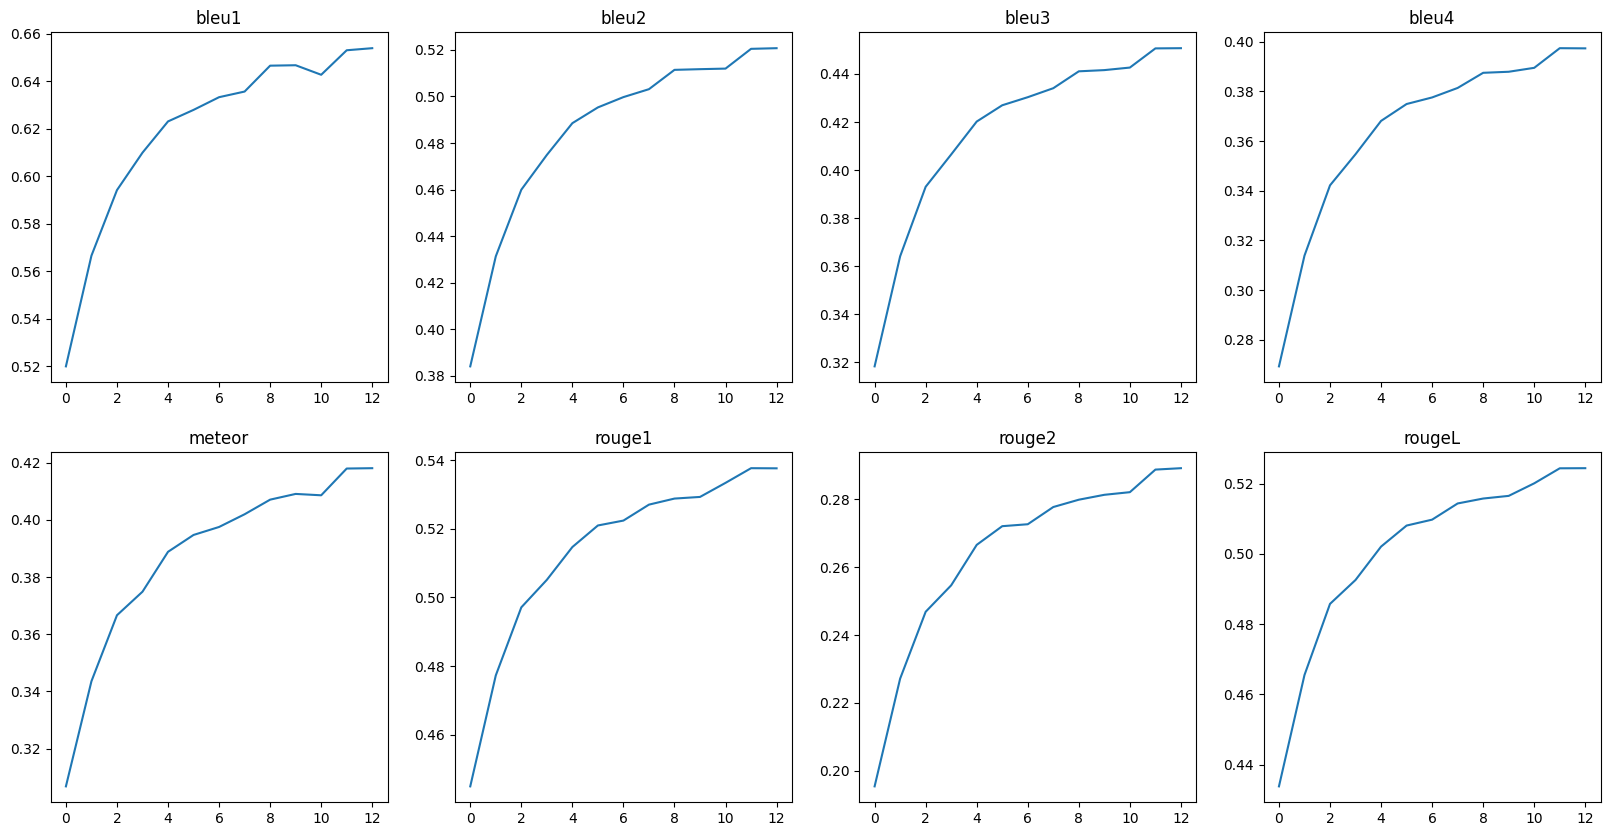

In [55]:
# Do a subplot for each metric
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i, key in enumerate(results_complete.keys()):
    axs[i//4, i%4].plot(results_complete[key])
    axs[i//4, i%4].set_title(key)

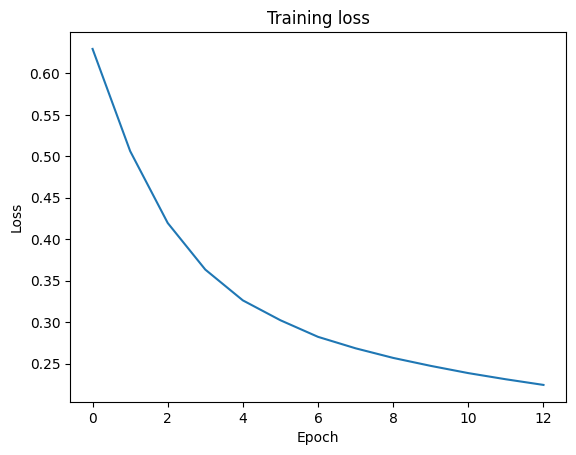

In [56]:
plt.plot(loss_hist)
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [58]:
# Load the best model
model.load_state_dict(torch.load('Translator_model_13.pth'))

<All keys matched successfully>

In [59]:
# Evaluating on the test set
compute_metrics(model, test_dataloader)

  0%|          | 0/257 [00:00<?, ?it/s]

100%|██████████| 257/257 [00:15<00:00, 16.71it/s]


{'bleu1': 0.6587249186254243,
 'bleu2': 0.527339099396375,
 'bleu3': 0.45838239595263586,
 'bleu4': 0.4054157011648424,
 'meteor': 0.42395250363991616,
 'rouge1': 0.5435795097962426,
 'rouge2': 0.296971015080959,
 'rougeL': 0.5307145570545894}

In [60]:
def show_examples(model, dataloader, num_examples):
    model.eval()
    counter_examples = 0
    special_tokens = ['<s>', '</s>', '<PAD>', '<UNK>']
    word2idx_Y_inv = {idx: word for word, idx in dataloader.dataset.word2idx_Y.items()}
    word2idx_X_inv = {idx: word for word, idx in dataloader.dataset.word2idx_X.items()}

    for inputs, targets in dataloader:
        with torch.no_grad():
            # Generate the model translations
            batch_size = inputs.size(0)
            inputs = inputs.to(model.device)
            outputs = model(inputs)
            outputs = outputs.max(2)[1]

            outputs = outputs.cpu().numpy()
            targets = targets.cpu().numpy()
            inputs = inputs.cpu().numpy()

            # Iterate over the batch
            for i in range(batch_size):
                # Convert indices to words and filter out special tokens
                outputs_i = outputs[i]
                targets_i = targets[i]
                inputs_i = inputs[i]

                outputs_i = [word2idx_Y_inv[idx] for idx in outputs_i]
                targets_i = [word2idx_Y_inv[idx] for idx in targets_i]
                inputs_i = [word2idx_X_inv[idx] for idx in inputs_i]

                outputs_i = [word for word in outputs_i if word not in special_tokens]
                targets_i = [word for word in targets_i if word not in special_tokens]
                inputs_i = [word for word in inputs_i if word not in special_tokens]

                targets_i = ' '.join(targets_i)
                outputs_i = ' '.join(outputs_i)
                inputs_i = ' '.join(inputs_i)

                print("Original:", inputs_i)
                print("Target:", targets_i)
                print("Prediction:", outputs_i)
                print()
                counter_examples += 1
                # Stop if we have shown the desired number of examples
                if counter_examples == num_examples:
                    return

show_examples(model, test_dataloader, num_examples=30)

Original: How many other guys named Tom do you know
Target: ¿A cuántos otros sujetos de nombre Tom conoces
Prediction: ¿Cuántas veces no no lo que

Original: I want one
Target: ¡Quiero una
Prediction: Quiero uno

Original: Tom has been convicted of drunken driving twice in the last four years
Target: Tom fue condenado por conducir en estado de ebriedad dos veces en los últimos cuatro años
Prediction: Tom ha estado condenado de conducción conducción de conducción de de los años de los últimos años años

Original: Perhaps Tom wo n't go to Boston
Target: Puede que Tom no vaya a Boston
Prediction: Quizás a Tom no no a Boston Boston

Original: I 've been patient my whole life
Target: He sido paciente toda mi vida
Prediction: He estado toda vida toda mi

Original: Some things are better left undone
Target: Algunas cosas es mejor sin hacer
Prediction: Ciertas cosas se quedan quedan

Original: Have you understood everything
Target: ¿Has entendido todo
Prediction: ¿Has has dado

Original: Do yo

## LSTM with Bhadanau Attention

In [61]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size, decoder_layer, device = 'cuda'):
        super(BahdanauAttention, self).__init__()
        self.hidden_size = hidden_size
        self.decoder_layer = decoder_layer
        self.softmax = nn.Softmax(dim=2)
        self.proj = nn.Linear(self.hidden_size, self.hidden_size)
        self.tanh = nn.Tanh()
        self.hidden_proj = nn.Linear(self.hidden_size, self.hidden_size)
        self.encoder_output_proj = nn.Linear(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        self.DEVICE = device

    def forward(self, hidden, encoder_output):
        # hidden -> layers, batch, features
        # encoder_output # batch, time_step, features
        hidden = hidden.permute(1, 2, 0) # batch, features, layers
        addMask = torch.FloatTensor([1/self.decoder_layer] * self.decoder_layer).view(1, self.decoder_layer, 1).to(self.DEVICE)
        addMask = torch.cat([addMask] * hidden.shape[0], dim=0)
        hidden = torch.bmm(hidden, addMask) # batch, feature, 1
        hidden = hidden.permute(0, 2, 1) # batch, 1, features
        hidden_attn = self.hidden_proj(hidden) # b, 1, f
        
        encoder_output_attn = self.encoder_output_proj(encoder_output) # t, b, f
        res_attn = self.tanh(encoder_output_attn + hidden_attn) # b, t, f
        out_attn = self.out(res_attn) # b, t, 1
        out_attn = out_attn.permute(0, 2, 1) # b, 1, t
        out_attn = self.softmax(out_attn) # b, 1, t
        return out_attn

In [62]:
# A version of our model with the attention mechanism, using Bahdanau attention
class Translator_Attention(nn.Module):
    def __init__(self, vocab_size_input, vocab_size_target, target_len, hidden_size=300, n_layers=1, dropout=0.1):
        super(Translator_Attention, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.target_len = target_len

        # Initialize the encoder and decoder
        self.embedding = nn.Embedding(vocab_size_input, hidden_size)
        self.lstm_enc = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        self.lstm_dec = nn.LSTM(hidden_size * 2, hidden_size, n_layers, batch_first=True)

        # Initialize the projection layer
        self.projection = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, vocab_size_target)
        )

        # Initialize the attention layer
        self.attention = BahdanauAttention(hidden_size, n_layers, self.device)

    def forward(self, input):
        batch_size = input.size(0)

        # Initialize the hidden and cell states
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(self.device)
        cell = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(self.device)

        # Embed the input tokens of the encoder
        embedded = self.embedding(input)
        # Pass the embedded tokens through the encoder
        out_enc, (hidden, cell) = self.lstm_enc(embedded, (hidden, cell))

        # Initialize the input of the decoder
        inp = torch.zeros(batch_size, self.hidden_size).to(self.device).unsqueeze(1)
        # Initialize the predictions tensor
        pred = self.projection(inp)
        for i in range(self.target_len - 1): # rm <SOS>
            # Compute the attention weights, given the current hidden state and the encoder output
            attention = self.attention(hidden, out_enc)
            # Compute the attention output
            out_attention = torch.bmm(attention, out_enc) # b, 1, f
            # Concatenate the attention output with the input and pass it through the decoder
            inp = torch.cat((inp, out_attention), dim=2)
            out, (hidden, cell) = self.lstm_dec(inp, (hidden, cell))

            # Project the output of the decoder and save it in the predictions tensor
            pred = torch.cat((pred, self.projection(out)), dim=1)
            # Update the input of the decoder
            inp = out

        return pred


In [177]:
# Initialize the model
model = Translator_Attention(len(train_dataset.vocab_X), len(train_dataset.vocab_Y), train_dataset.MAX_LENGTH_out+2)
model.to(model.device)

Translator_Attention(
  (embedding): Embedding(14167, 300)
  (lstm_enc): LSTM(300, 300, batch_first=True)
  (lstm_dec): LSTM(600, 300, batch_first=True)
  (projection): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=300, out_features=27915, bias=True)
  )
  (attention): BahdanauAttention(
    (softmax): Softmax(dim=2)
    (proj): Linear(in_features=300, out_features=300, bias=True)
    (tanh): Tanh()
    (hidden_proj): Linear(in_features=300, out_features=300, bias=True)
    (encoder_output_proj): Linear(in_features=300, out_features=300, bias=True)
    (out): Linear(in_features=300, out_features=1, bias=True)
  )
)

In [ ]:
# Define the optimizer and loss function
optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()

results_complete, loss_hist = train(model, optimizer, criterion, train_dataloader, num_epochs=10)

In [178]:
# Load the best model
model.load_state_dict(torch.load('best_model_15.pth'))

<All keys matched successfully>

In [ ]:
# Do a subplot for each metric
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i, key in enumerate(results_complete.keys()):
    axs[i//4, i%4].plot(results_complete[key])
    axs[i//4, i%4].set_title(key)

In [ ]:
plt.plot(loss_hist)
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [65]:
# Evaluating on the test set
compute_metrics(model, test_dataloader)

100%|██████████| 257/257 [00:23<00:00, 11.02it/s]


{'bleu1': 0.703852573802549,
 'bleu2': 0.5892827048085753,
 'bleu3': 0.5242938133038587,
 'bleu4': 0.47317917882890975,
 'meteor': 0.498231652719249,
 'rouge1': 0.6009285538348157,
 'rouge2': 0.364605186848296,
 'rougeL': 0.5883671894393528}

In [66]:
show_examples(model, test_dataloader, num_examples=30)

Original: How many other guys named Tom do you know
Target: ¿A cuántos otros sujetos de nombre Tom conoces
Prediction: ¿Cuántos Tom Tom Tom Tom sabés

Original: I want one
Target: ¡Quiero una
Prediction: Quiero uno

Original: Tom has been convicted of drunken driving twice in the last four years
Target: Tom fue condenado por conducir en estado de ebriedad dos veces en los últimos cuatro años
Prediction: Tom ha estado condenado de conducción de de efectos efectos efectos efectos veces de últimos últimos últimos años años

Original: Perhaps Tom wo n't go to Boston
Target: Puede que Tom no vaya a Boston
Prediction: Quizá Tom no se a a Boston

Original: I 've been patient my whole life
Target: He sido paciente toda mi vida
Prediction: He toda paciente vida mi vida

Original: Some things are better left undone
Target: Algunas cosas es mejor sin hacer
Prediction: Algunas cosas son mejores se

Original: Have you understood everything
Target: ¿Has entendido todo
Prediction: ¿Has todo todo

Ori

In [94]:
train_dataset.lines

tensor([[  245,   245,   245,  ...,  3155, 13087,   244],
        [  245,   245,   245,  ...,  2435, 12946,   244],
        [  245,   245,   245,  ..., 14145,  4397,   244],
        ...,
        [  245,   245,   245,  ...,  1856,  6737,   244],
        [  245,   245,   245,  ...,  6459,  8246,   244],
        [  245,   245,   245,  ..., 12988,  8967,   244]])

## Plotting the attention maps

In [ ]:
# Create the hook for the attention layer
attention_weights = []
def attention_hook(module, input, output):
    attention_weights.append(output)

# Register the hook
hook_handle = model.attention.register_forward_hook(attention_hook)

In [276]:
# Put the model in evaluation mode
model.eval()
# Select a sentence to translate
sentence = "Tom got angry when he saw Mary with John"
sentence_dataset = Dataset_Translation([sentence + '\t' + ''], 
                                       word2idx_X=train_dataset.word2idx_X, 
                                       word2idx_Y=train_dataset.word2idx_Y)

target2idx = {idx: word for word, idx in train_dataset.word2idx_Y.items()}

100%|██████████| 1/1 [00:00<00:00, 3109.19it/s]


In [277]:
# Make the forward pass
sentence_tokenize = sentence_dataset.X.to(model.device)
pred = model(sentence_tokenize)
# Get the predictions
pred_sentence = pred.max(2)[1].cpu().numpy()[0]
# Take out the special tokens
pred_idx_words = [word for word in pred_sentence if word not in (233, 231)]
pred_words = [target2idx[word] for word in pred_idx_words]

In [280]:
attention_weights_ = torch.cat(attention_weights).squeeze(1)

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 23 but got size 21 for tensor number 100 in the list.

In [252]:
associate_att_weights = attention_weights_[:pred_sentence.split().__len__()]

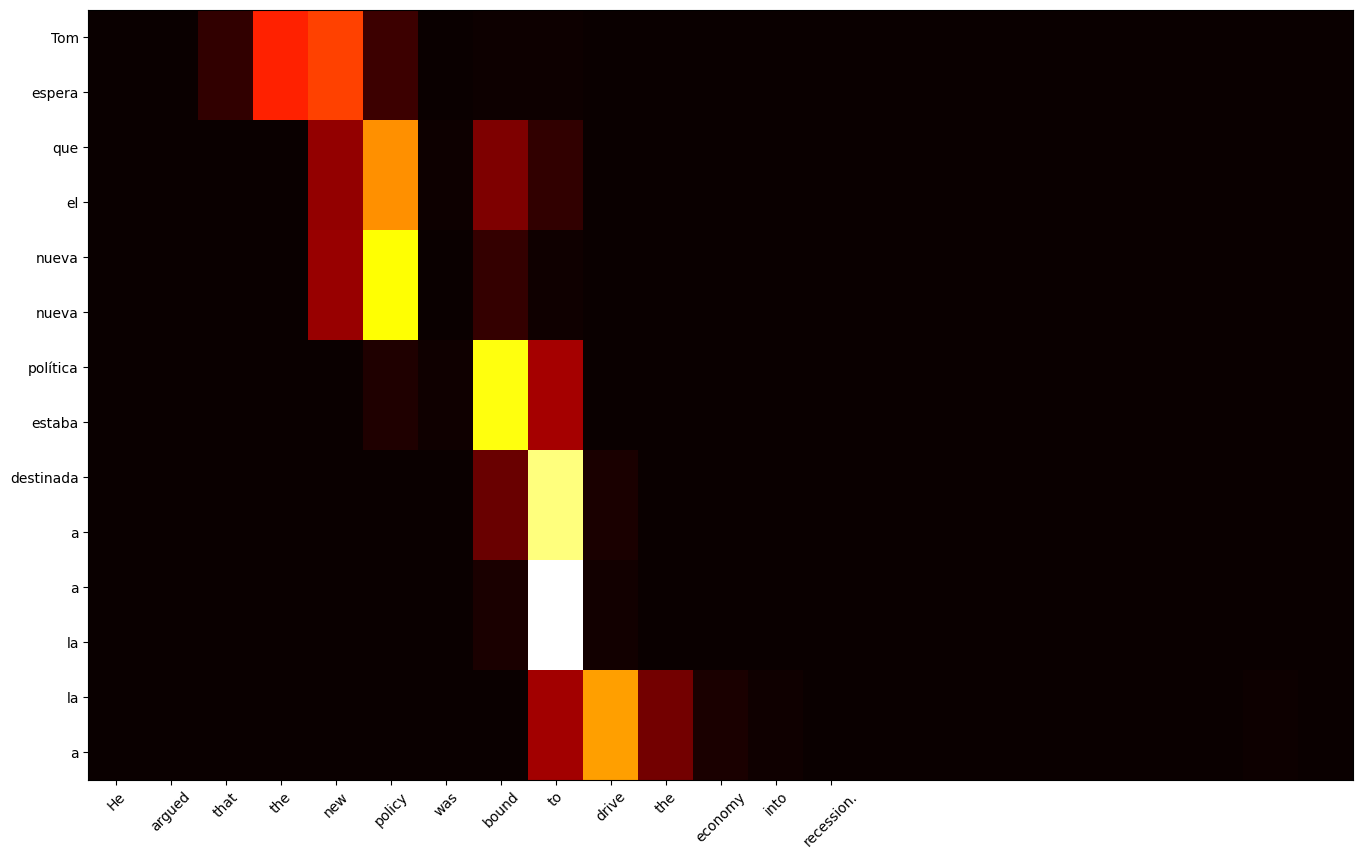

In [253]:
# Plot the attention weights
plt.figure(figsize=(20, 10))
plt.imshow(associate_att_weights.cpu().detach().numpy(), cmap='hot')
# Set the x-axis labels to the words of the input sentence
l = plt.xticks(range(len(sentence.split())), sentence.split(), rotation=45)
# Set the y-axis labels to the words of the output sentence
d = plt.yticks(range(len(pred_sentence.split())), pred_sentence.split())